In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'SimHei' 
plt.rcParams['mathtext.fontset'] = 'stix'  # 使用STIX字体，支持数学符号
plt.rcParams['mathtext.default'] = 'regular'  # 默认数学文本样式

数据基本信息:
总样本数: 605
T21正样本数: 13, 比例: 0.0215
缺失值情况:
孕妇BMI          0
13号染色体的Z值      0
18号染色体的Z值      0
21号染色体的Z值      0
X染色体的Z值        0
X染色体浓度         0
13号染色体的GC含量    0
18号染色体的GC含量    0
21号染色体的GC含量    0
参考基因读段数        0
参考基因实际读段数      0
参考基因唯一比对读段数    0
dtype: int64

训练集: (484, 12), T21比例: 0.0207
测试集: (121, 12), T21比例: 0.0248
类别权重 (scale_pos_weight): 47.40

开始训练XGBoost模型...
[0]	validation_0-auc:0.09746
[50]	validation_0-auc:0.37571
[54]	validation_0-auc:0.36723

=== 模型评估结果 ===
AUC: 0.4873

分类报告:
              precision    recall  f1-score   support

          健康       0.97      0.95      0.96       118
         T21       0.00      0.00      0.00         3

    accuracy                           0.93       121
   macro avg       0.49      0.47      0.48       121
weighted avg       0.95      0.93      0.94       121

混淆矩阵:
[[112   6]
 [  3   0]]

特征重要性排序:
        feature  importance
5        X染色体浓度    0.145115
0         孕妇BMI    0.105267
6   13号染色体的GC含量    0.101438
11  参考基因唯一比对读段数    0.0

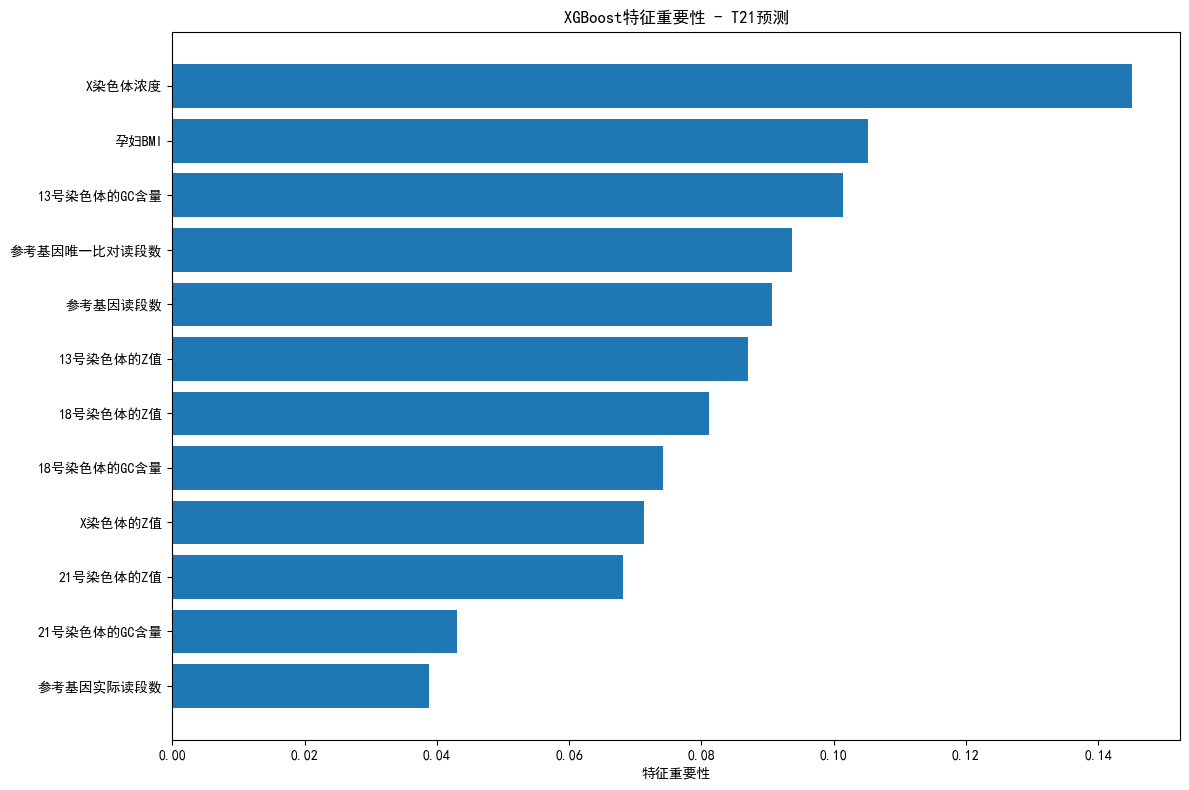

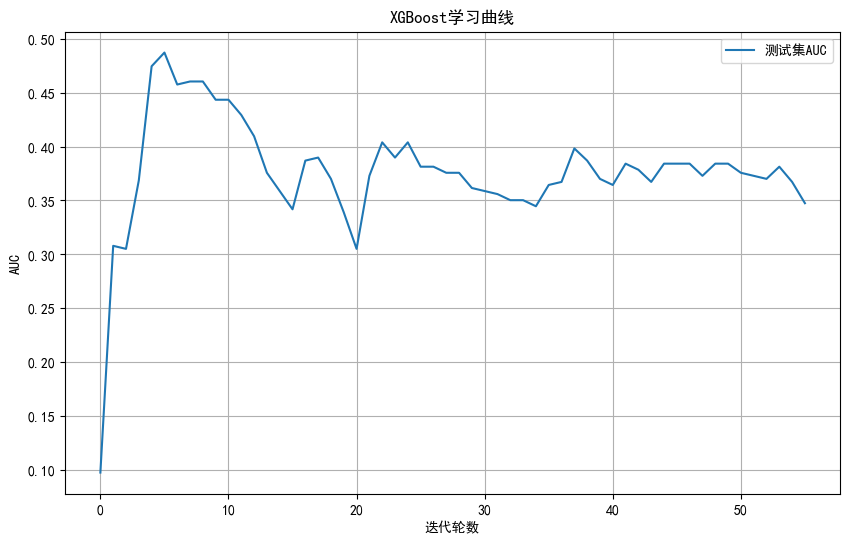

最佳迭代轮数: 5

使用最佳迭代轮数重新训练...
最终模型AUC: 0.4068

预测概率分布分析:
预测概率范围: [0.3663, 0.5278]
预测概率均值: 0.4060
T21样本预测概率均值: 0.3923
健康样本预测概率均值: 0.4063


In [7]:
df = pd.read_excel("附件_降维_XX.xlsx")

# 特征列表
covars = ["孕妇BMI", "13号染色体的Z值", "18号染色体的Z值", "21号染色体的Z值", "X染色体的Z值", 
          "X染色体浓度", "13号染色体的GC含量", "18号染色体的GC含量", "21号染色体的GC含量",
          "参考基因读段数", "参考基因实际读段数", "参考基因唯一比对读段数"]

target = "T21"  # 专注于T21预测

# 数据准备
X = df[covars].copy()
y = df[target].copy()

# 检查数据基本信息
print("数据基本信息:")
print(f"总样本数: {len(X)}")
print(f"T21正样本数: {y.sum()}, 比例: {y.mean():.4f}")
print(f"缺失值情况:\n{X.isnull().sum()}")

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=covars)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n训练集: {X_train.shape}, T21比例: {y_train.mean():.4f}")
print(f"测试集: {X_test.shape}, T21比例: {y_test.mean():.4f}")

# 计算类别权重（处理不平衡数据）
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
print(f"类别权重 (scale_pos_weight): {scale_pos_weight:.2f}")

# 创建XGBoost模型
xgb_model = XGBClassifier(
    n_estimators=100,           # 树的数量
    max_depth=5,                 # 树的最大深度
    learning_rate=0.05,          # 学习率
    subsample=0.8,               # 样本采样比例
    colsample_bytree=0.8,        # 特征采样比例
    scale_pos_weight=scale_pos_weight,  # 处理类别不平衡
    random_state=42,             # 随机种子
    eval_metric='auc',           # 评估指标
    use_label_encoder=False,     # 避免警告
    early_stopping_rounds=50,    # 早停轮数
    reg_alpha=0.1,               # L1正则化
    reg_lambda=0.3               # L2正则化
)

# 训练模型
print("\n开始训练XGBoost模型...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # 早停用的验证集
    verbose=50                    # 每50轮输出一次信息
)

# 预测
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # 正类的概率
y_pred = (y_pred_proba > 0.5).astype(int)  # 二分类预测

# 评估模型
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\n=== 模型评估结果 ===")
print(f"AUC: {auc_score:.4f}")

# 详细分类报告
print("\n分类报告:")
print(classification_report(y_test, y_pred, target_names=['健康', 'T21']))

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print("混淆矩阵:")
print(cm)

# 特征重要性
feature_importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': covars,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\n特征重要性排序:")
print(feature_importance_df)

# 可视化特征重要性
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('特征重要性')
plt.title('XGBoost特征重要性 - T21预测')
plt.gca().invert_yaxis()  # 最重要的特征在顶部
plt.tight_layout()
plt.show()

# 学习曲线
results = xgb_model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['auc'], label='测试集AUC')
plt.xlabel('迭代轮数')
plt.ylabel('AUC')
plt.title('XGBoost学习曲线')
plt.legend()
plt.grid(True)
plt.show()

# 保存最佳迭代轮数
best_iteration = xgb_model.best_iteration
print(f"最佳迭代轮数: {best_iteration}")

# 使用最佳迭代轮数重新训练（可选）
if best_iteration is not None:
    print("\n使用最佳迭代轮数重新训练...")
    xgb_model_final = XGBClassifier(
        n_estimators=best_iteration,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        use_label_encoder=False
    )
    xgb_model_final.fit(X_train, y_train)
    
    # 重新评估
    y_pred_proba_final = xgb_model_final.predict_proba(X_test)[:, 1]
    auc_final = roc_auc_score(y_test, y_pred_proba_final)
    print(f"最终模型AUC: {auc_final:.4f}")

# 预测概率分布分析
print("\n预测概率分布分析:")
print(f"预测概率范围: [{y_pred_proba.min():.4f}, {y_pred_proba.max():.4f}]")
print(f"预测概率均值: {y_pred_proba.mean():.4f}")
print(f"T21样本预测概率均值: {y_pred_proba[y_test == 1].mean():.4f}")
print(f"健康样本预测概率均值: {y_pred_proba[y_test == 0].mean():.4f}") 

In [8]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f"   逻辑回归AUC: {lr_auc:.4f}")

   逻辑回归AUC: 0.4944
